# Import Library

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import category_encoders as ce

from sklearn.preprocessing import RobustScaler
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_percentage_error, explained_variance_score, mean_absolute_error, mean_squared_error, r2_score

import plotly.express as px
import plotly.graph_objects as go

import re
import gc

# Read Data

In [2]:
data_flight = pd.read_csv('narita_airport.csv')
data_flight.head()

,FLIGHT_NO,ACTUAL_TIME,SCHEDULED_TIME,OTP,FROM_STATION,TO_STATION,TERMINAL,CAPACITY,TOTAL_PAX,CATEGORY_CODE,CHECK_IN_COUNTER,LEG,REMARK
0,JL3009,2015-01-01 19:07:00,2015-01-01 18:30:00,EARLY,NRT,ITM,2 (Domestic),162.0,88.0,Domestic,1F,Departure,Departed
1,NH920,2015-01-01 16:39:00,2015-01-01 16:55:00,CAT_1,PVG,NRT,1 (International/South),199.0,145.0,International,NaN,Arrival,Landed
2,NH919,2015-01-01 09:42:00,2015-01-01 09:20:00,EARLY,NRT,PVG,1 (International/South),284.0,129.0,International,4F,Departure,Departed
3,GK203,2015-01-01 10:21:00,2015-01-01 10:10:00,EARLY,NRT,KIX,3 (Domestic),162.0,144.0,Domestic,2F,Departure,Departed
4,NH956,2015-01-01 18:50:00,2015-01-01 18:40:00,EARLY,PEK,NRT,1 (International/South),162.0,140.0,International,NaN,Arrival,Landed


# Checking Null Data

First of all that i want to do is to check the null value in dataset, because if there is a lot of null value it will be pain in the head to impute it :)

## Checking Null

In [3]:
data_flight.isnull().sum()

FLIGHT_NO                0
ACTUAL_TIME              0
SCHEDULED_TIME           0
OTP                      0
FROM_STATION             0
TO_STATION               0
TERMINAL                 0
CAPACITY                 0
TOTAL_PAX                0
CATEGORY_CODE            0
CHECK_IN_COUNTER    240673
LEG                      0
REMARK                   0
dtype: int64

In [4]:
data_flight[data_flight.CHECK_IN_COUNTER.isnull()]

,FLIGHT_NO,ACTUAL_TIME,SCHEDULED_TIME,OTP,FROM_STATION,TO_STATION,TERMINAL,CAPACITY,TOTAL_PAX,CATEGORY_CODE,CHECK_IN_COUNTER,LEG,REMARK
1,NH920,2015-01-01 16:39:00,2015-01-01 16:55:00,CAT_1,PVG,NRT,1 (International/South),199.0,145.0,International,NaN,Arrival,Landed
4,NH956,2015-01-01 18:50:00,2015-01-01 18:40:00,EARLY,PEK,NRT,1 (International/South),162.0,140.0,International,NaN,Arrival,Landed
8,GK200,2015-01-01 09:53:00,2015-01-01 09:25:00,EARLY,KIX,NRT,3 (Domestic),162.0,96.0,Domestic,NaN,Arrival,Landed
9,GK202,2015-01-01 13:55:00,2015-01-01 13:50:00,EARLY,KIX,NRT,3 (Domestic),162.0,125.0,Domestic,NaN,Arrival,Landed
10,GK204,2015-01-01 15:53:00,2015-01-01 16:05:00,CAT_1,KIX,NRT,3 (Domestic),215.0,191.0,Domestic,NaN,Arrival,Landed
...,...,...,...,...,...,...,...,...,...,...,...,...,...
472445,GK102,2023-05-06 10:54:00,2023-05-06 10:50:00,EARLY,CTS,NRT,3 (Domestic),506.0,217.0,Domestic,NaN,Arrival,Landed
472446,GK504,2023-05-06 14:32:00,2023-05-06 13:55:00,EARLY,FUK,NRT,3 (Domestic),156.0,154.0,Domestic,NaN,Arrival,Landed
472448,GK408,2023-05-06 12:20:00,2023-05-06 12:15:00,EARLY,MYJ,NRT,3 (Domestic),215.0,184.0,Domestic,NaN,Arrival,Landed
472449,GK104,2023-05-06 12:25:00,2023-05-06 12:05:00,EARLY,CTS,NRT,3 (Domestic),215.0,185.0,Domestic,NaN,Arrival,Landed


From the data above the <b>CHECK_IN_COUNTER</b> value had the most null value, and when we slicing it the <b>LEG</b> column looks like had only one value. We gonna check it first

In [5]:
data_flight[data_flight.CHECK_IN_COUNTER.isnull()].LEG.unique()

array(['Arrival'], dtype=object)

Yapp!!!! it only had <b><i>Arrival</i></b> value in <b>LEG</b> column. So this is make sense, because we don't need to <i>Check In</i> again when we Arrived or Landed in the Airport. Generally when passangger landed into airport, they can go or get the baggage in the conveyor belt. The <b><i>Arrival</i></b> for <b>LEG</b> can be determined with the conveyor belt, to trace where the passanger move.

# Explorary Data Analysis

## Fill Null in Check In Counter

In [6]:
data_flight.CHECK_IN_COUNTER = data_flight.CHECK_IN_COUNTER.fillna('ARRIVAL_CHECK_IN')
data_flight.CHECK_IN_COUNTER.unique()

array(['1F', 'ARRIVAL_CHECK_IN', '4F', '2F', '3F'], dtype=object)

Because the null value only in <b>CHECK_IN_COUNTER</b>, we can fill null with <b><i>ARRIVAL_CHECK_IN</i></b>

## Change Data Object to Datetime

In [7]:
for cols in ["ACTUAL_TIME", "SCHEDULED_TIME"]:
    data_flight[cols] = pd.to_datetime(data_flight[cols])

In [8]:
data_flight.ACTUAL_TIME.head(1), data_flight.SCHEDULED_TIME.head(1)

(0   2015-01-01 19:07:00
 Name: ACTUAL_TIME, dtype: datetime64[ns],
 0   2015-01-01 18:30:00
 Name: SCHEDULED_TIME, dtype: datetime64[ns])

## Create Column Date

In [9]:
data_flight["DATE"] = pd.to_datetime(data_flight["SCHEDULED_TIME"].dt.strftime('%Y-%m-%d'))

Just adding <b>DATE</b> column, it will be used for aggregation

## Feature Engineering Part 1

### Extract Airline Name & Code

In [10]:
def ExtractAirlineCode(
    text : str
) -> str:
    patternAirlineCode = re.compile(r".?\w")
    value = patternAirlineCode.findall(text)
    return value[0]

In [11]:
# Extract Airline Code from Filght Number
data_flight["AIRLINE_CODE"] = data_flight.FLIGHT_NO.apply(ExtractAirlineCode)

In [12]:
data_flight["AIRLINE_CODE"].unique()

array(['JL', 'NH', 'GK', 'TR', 'SQ', 'MM', 'BR', 'JQ', 'KE', 'OD', 'IJ',
       'EK', 'CZ', 'CX', 'EY', 'ET', '5J', 'KL', 'GA'], dtype=object)

From the airline code above, we search the airline name in website, source: https://www.narita-airport.jp/en/t_info<br>
after we list all the airline name, we mapping the airline code with the airline name

In [13]:
# Mapping all the airline
mapping_airline = {
    "JL":"Japan Airlines",
    "NH":"All Nippon Airways",
    "GK":"Jetstar Japan",
    "TR":"Scoot",
    "SQ":"Singapore Airlines",
    "MM":"Peach Aviation Limited",
    "BR":"Eva Airways",
    "JQ":"Jetstar Airways",
    "KE":"Korean Air",
    "OD":"Batik Air Malaysia (Malindo)",
    "IJ":"Spring Japan Airlines",
    "EK":"Emirates",
    "CZ":"China Southern Airlines",
    "CX":"Cathay Pacific",
    "EY":"Etihad Airways",
    "5J":"Cebu Pacific Air",
    "KL":"KLM",
    "GA":"Garuda Indonesia",
    "ET":"Ethiopian Airlines"
}

In [14]:
# mapping the airline code
data_flight["AIRLINE_NAME"] = data_flight["AIRLINE_CODE"].map(mapping_airline)

## Create Group Column

In [15]:
data_flight['GROUPER'] = data_flight['TERMINAL'] + '-' + data_flight['AIRLINE_NAME'] + '-' + data_flight['CATEGORY_CODE'] + '-' + data_flight['LEG'] 

In [16]:
data_flight.GROUPER

0            2 (Domestic)-Japan Airlines-Domestic-Departure
1         1 (International/South)-All Nippon Airways-Int...
2         1 (International/South)-All Nippon Airways-Int...
3             3 (Domestic)-Jetstar Japan-Domestic-Departure
4         1 (International/South)-All Nippon Airways-Int...
                                ...                        
472447    2 (International)-Cathay Pacific-International...
472448          3 (Domestic)-Jetstar Japan-Domestic-Arrival
472449          3 (Domestic)-Jetstar Japan-Domestic-Arrival
472450    1 (International/South)-All Nippon Airways-Int...
472451    2 (International)-Cebu Pacific Air-Internation...
Name: GROUPER, Length: 472452, dtype: object

This <b>GROUPER</b> column will be used to aggregate the dataset

### Create Difference Actual - Scheduled (Delay Time)

In [17]:
# create average delay in minute
data_flight["AVG_DELAY_MINUTE"] = (pd.to_datetime(data_flight['SCHEDULED_TIME'])-pd.to_datetime(data_flight['ACTUAL_TIME'])).dt.total_seconds()/60

In [18]:
data_flight.head()

,FLIGHT_NO,ACTUAL_TIME,SCHEDULED_TIME,OTP,FROM_STATION,TO_STATION,TERMINAL,CAPACITY,TOTAL_PAX,CATEGORY_CODE,CHECK_IN_COUNTER,LEG,REMARK,DATE,AIRLINE_CODE,AIRLINE_NAME,GROUPER,AVG_DELAY_MINUTE
0,JL3009,2015-01-01 19:07:00,2015-01-01 18:30:00,EARLY,NRT,ITM,2 (Domestic),162.0,88.0,Domestic,1F,Departure,Departed,2015-01-01,JL,Japan Airlines,2 (Domestic)-Japan Airlines-Domestic-Departure,-37.0
1,NH920,2015-01-01 16:39:00,2015-01-01 16:55:00,CAT_1,PVG,NRT,1 (International/South),199.0,145.0,International,ARRIVAL_CHECK_IN,Arrival,Landed,2015-01-01,NH,All Nippon Airways,1 (International/South)-All Nippon Airways-Int...,16.0
2,NH919,2015-01-01 09:42:00,2015-01-01 09:20:00,EARLY,NRT,PVG,1 (International/South),284.0,129.0,International,4F,Departure,Departed,2015-01-01,NH,All Nippon Airways,1 (International/South)-All Nippon Airways-Int...,-22.0
3,GK203,2015-01-01 10:21:00,2015-01-01 10:10:00,EARLY,NRT,KIX,3 (Domestic),162.0,144.0,Domestic,2F,Departure,Departed,2015-01-01,GK,Jetstar Japan,3 (Domestic)-Jetstar Japan-Domestic-Departure,-11.0
4,NH956,2015-01-01 18:50:00,2015-01-01 18:40:00,EARLY,PEK,NRT,1 (International/South),162.0,140.0,International,ARRIVAL_CHECK_IN,Arrival,Landed,2015-01-01,NH,All Nippon Airways,1 (International/South)-All Nippon Airways-Int...,-10.0


## Univariate Analysis

In [19]:
data_flight.CATEGORY_CODE.value_counts()

Domestic         348131
International    124321
Name: CATEGORY_CODE, dtype: int64

From the value counts on <b>CATEGORY_CODE</b> column, we can see that <i>Domestic</i> flight is more than <i>International</i>. So we can be separate domestic and international for univariate analysis

In [20]:
domestic_flight = data_flight[data_flight.CATEGORY_CODE == "Domestic"]
international_flight = data_flight[data_flight.CATEGORY_CODE != "Domestic"]

### OTP

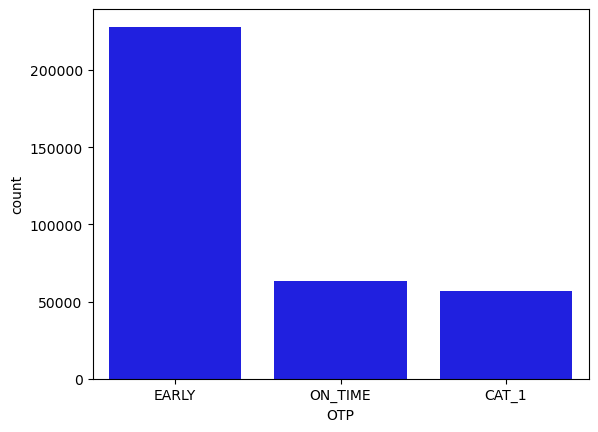

In [21]:
# Domestic FLight
sns.countplot(x = 'OTP', data = domestic_flight, color = 'blue', 
              order = domestic_flight['OTP'].value_counts().index);

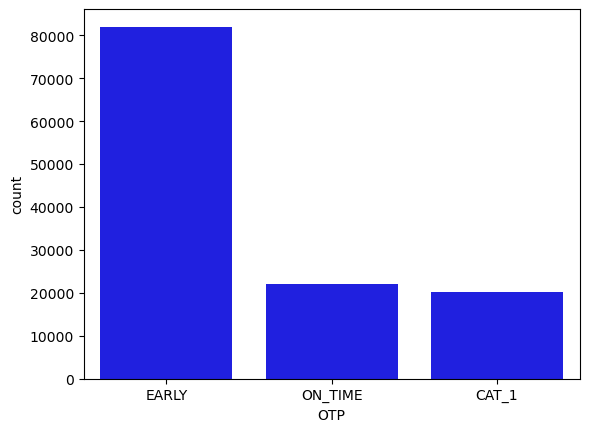

In [22]:
# International FLight
sns.countplot(x = 'OTP', data = international_flight, color = 'blue', 
              order = international_flight['OTP'].value_counts().index);

From the OTP (On Time Performance), it seems like either Domestic and International Flight had an early flight and on time flight. Well it was nothing surprised. We talk about Japan The Country that well known for it very discipline and dedicated in all aspect.

### Terminal

[Text(0, 0, '3 (Domestic)'),
 Text(1, 0, '1 (Domestic)'),
 Text(2, 0, '2 (Domestic)')]

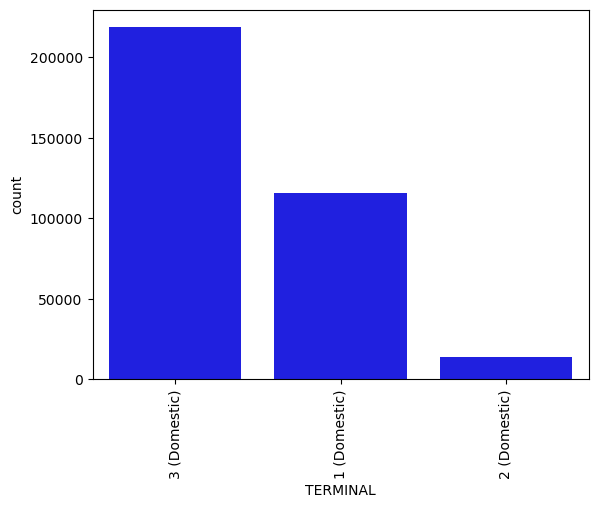

In [23]:
# Domestic FLight
plot_viz = sns.countplot(x = 'TERMINAL', data = domestic_flight, color = 'blue', 
              order = domestic_flight['TERMINAL'].value_counts().index);
loc, labels = plt.xticks()
plot_viz.set_xticklabels(labels, rotation=90)

[Text(0, 0, '1 (International/South)'),
 Text(1, 0, '2 (International)'),
 Text(2, 0, '1 (International/North)'),
 Text(3, 0, '3 (International)')]

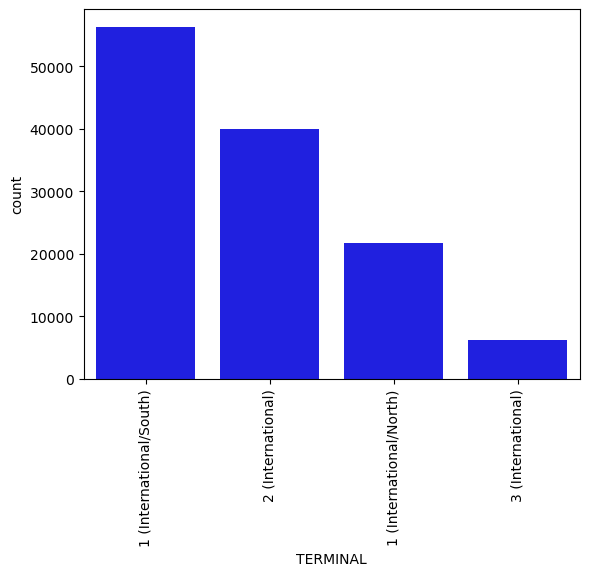

In [24]:
# International FLight
plot_viz = sns.countplot(x = 'TERMINAL', data = international_flight, color = 'blue', 
              order = international_flight['TERMINAL'].value_counts().index);
loc, labels = plt.xticks()
plot_viz.set_xticklabels(labels, rotation=90)

From The Terminal, we can see the flight from Terminal 3 (Domestic) and Terminal 1 (International/South) had a very crowded flight.

### Leg

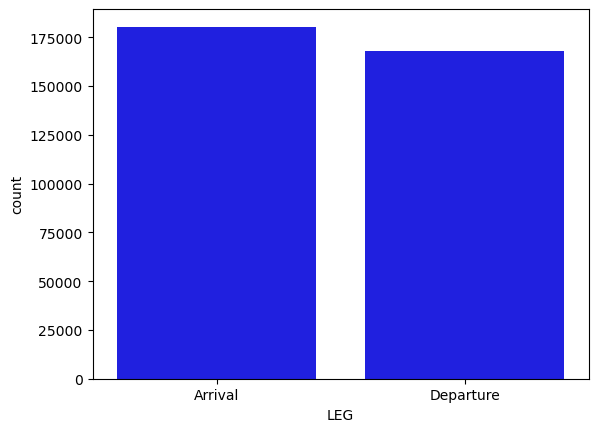

In [25]:
# Domestic Flight
sns.countplot(x = 'LEG', data = domestic_flight, color = 'blue', 
              order = domestic_flight['LEG'].value_counts().index);

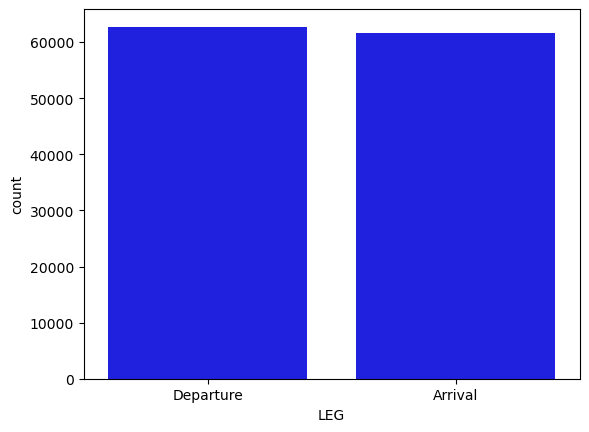

In [26]:
# International Flight
sns.countplot(x = 'LEG', data = international_flight, color = 'blue', 
              order = international_flight['LEG'].value_counts().index);

The arrival and departure for domestic and international flight is well balance. It means the there is no plane that parking to long in the Airport

### Airline Name

[Text(0, 0, 'Jetstar Japan'),
 Text(1, 0, 'Peach Aviation Limited'),
 Text(2, 0, 'Spring Japan Airlines'),
 Text(3, 0, 'Japan Airlines'),
 Text(4, 0, 'All Nippon Airways')]

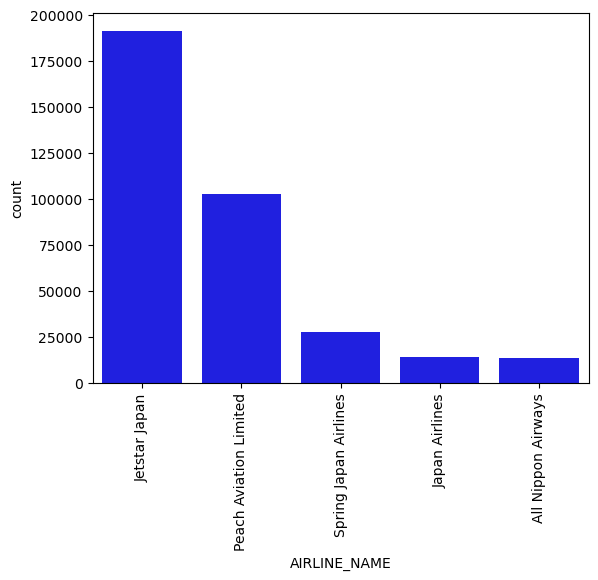

In [27]:
# Domestic Flight
plot_viz = sns.countplot(x = 'AIRLINE_NAME', data = domestic_flight, color = 'blue', 
              order = domestic_flight['AIRLINE_NAME'].value_counts().index[:10]);
loc, labels = plt.xticks()
plot_viz.set_xticklabels(labels, rotation=90)

[Text(0, 0, 'All Nippon Airways'),
 Text(1, 0, 'Japan Airlines'),
 Text(2, 0, 'Cathay Pacific'),
 Text(3, 0, 'Cebu Pacific Air'),
 Text(4, 0, 'Korean Air'),
 Text(5, 0, 'Eva Airways'),
 Text(6, 0, 'Singapore Airlines'),
 Text(7, 0, 'Batik Air Malaysia (Malindo)'),
 Text(8, 0, 'Jetstar Airways'),
 Text(9, 0, 'China Southern Airlines')]

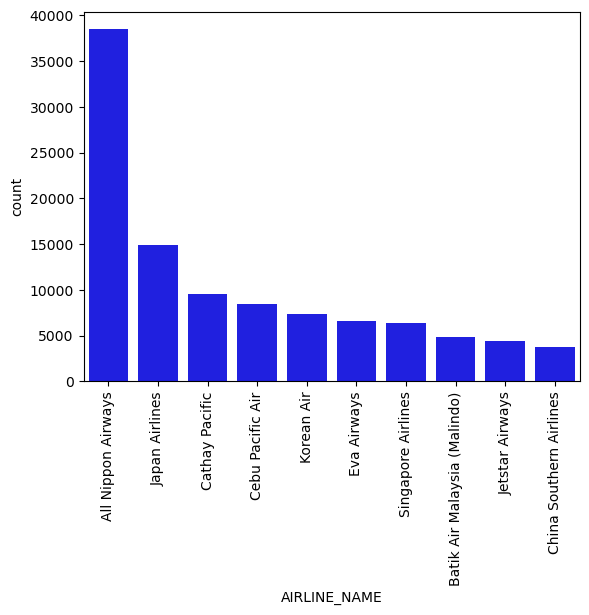

In [28]:
# International Flight
plot_viz = sns.countplot(x = 'AIRLINE_NAME', data = international_flight, color = 'blue', 
              order = international_flight['AIRLINE_NAME'].value_counts().index[:10]);
loc, labels = plt.xticks()
plot_viz.set_xticklabels(labels, rotation=90)

For Domestic Flight the most busy airline was Jetstar Japan meanwhile for International Flight it was ANA (All Nippon Airways)

### From Station

[Text(0, 0, 'CTS'),
 Text(1, 0, 'FUK'),
 Text(2, 0, 'KIX'),
 Text(3, 0, 'OKA'),
 Text(4, 0, 'NGO'),
 Text(5, 0, 'KMJ'),
 Text(6, 0, 'MYJ'),
 Text(7, 0, 'TAK'),
 Text(8, 0, 'OIT')]

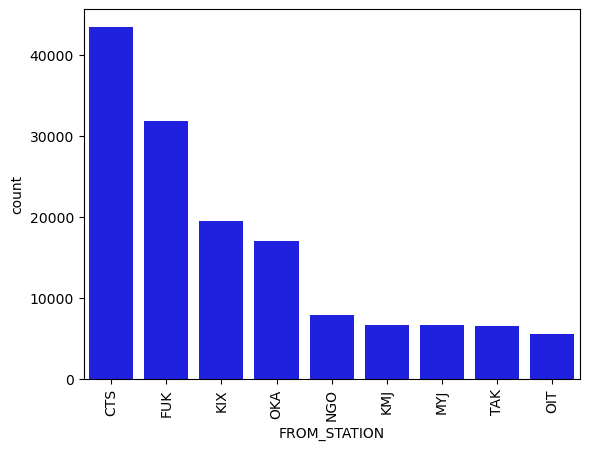

In [29]:
# Domestic Flight
plot_viz = sns.countplot(x = 'FROM_STATION', data = domestic_flight, color = 'blue', 
              order = domestic_flight['FROM_STATION'].value_counts().index[1:10]);
loc, labels = plt.xticks()
plot_viz.set_xticklabels(labels, rotation=90)

[Text(0, 0, 'TPE'),
 Text(1, 0, 'HKG'),
 Text(2, 0, 'KUL'),
 Text(3, 0, 'HNL'),
 Text(4, 0, 'AMS'),
 Text(5, 0, 'SIN'),
 Text(6, 0, 'ICN'),
 Text(7, 0, 'BOS'),
 Text(8, 0, 'MNL')]

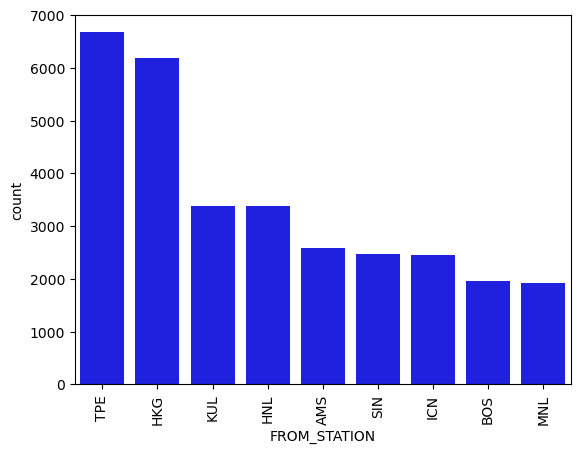

In [30]:
# International Flight
plot_viz = sns.countplot(x = 'FROM_STATION', data = international_flight, color = 'blue', 
              order = international_flight['FROM_STATION'].value_counts().index[1:10]);
loc, labels = plt.xticks()
plot_viz.set_xticklabels(labels, rotation=90)

For domestic flights, the most frequent route to Narita Airport (NRT) is from New Chitose (CTS). For international flights, the highest number of flights to Narita come from Taipei (TPE) and Hong Kong (HKG).

### To Station

[Text(0, 0, 'CTS'),
 Text(1, 0, 'FUK'),
 Text(2, 0, 'KIX'),
 Text(3, 0, 'OKA'),
 Text(4, 0, 'OIT'),
 Text(5, 0, 'KMJ'),
 Text(6, 0, 'TAK'),
 Text(7, 0, 'NGO'),
 Text(8, 0, 'MYJ')]

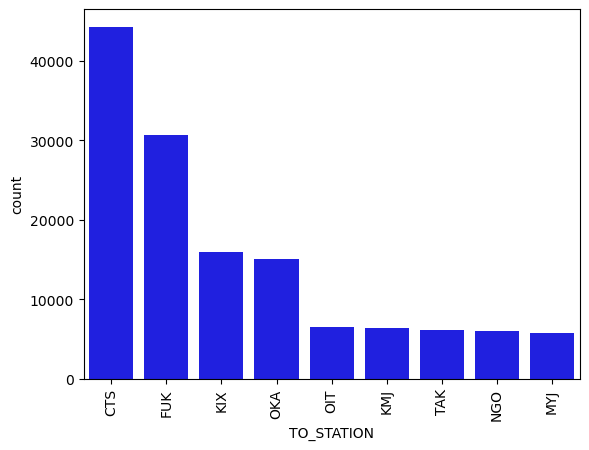

In [31]:
# Domestic flight
plot_viz = sns.countplot(x = 'TO_STATION', data = domestic_flight, color = 'blue', 
              order = domestic_flight['TO_STATION'].value_counts().index[1:10]);
loc, labels = plt.xticks()
plot_viz.set_xticklabels(labels, rotation=90)

[Text(0, 0, 'HKG'),
 Text(1, 0, 'SIN'),
 Text(2, 0, 'MNL'),
 Text(3, 0, 'TPE'),
 Text(4, 0, 'KUL'),
 Text(5, 0, 'LAX'),
 Text(6, 0, 'HNL'),
 Text(7, 0, 'CRK'),
 Text(8, 0, 'ICN')]

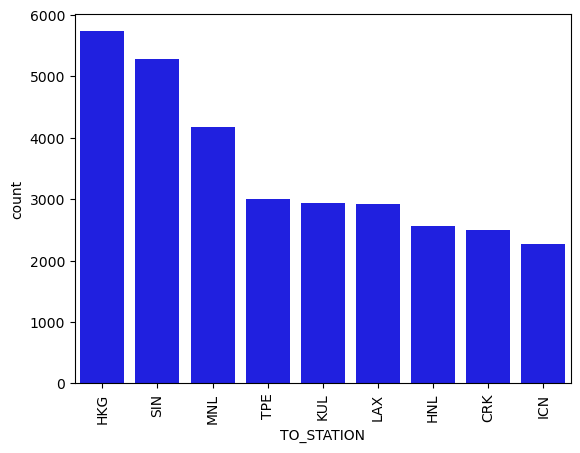

In [32]:
# International flight
plot_viz = sns.countplot(x = 'TO_STATION', data = international_flight, color = 'blue', 
              order = international_flight['TO_STATION'].value_counts().index[1:10]);
loc, labels = plt.xticks()
plot_viz.set_xticklabels(labels, rotation=90)

We can observe that for domestic flights, the route to New Chitose (CTS) is the most frequent at Narita Airport (NRT). As for international flights, the busiest routes from Narita are to Hong Kong (HKG), Singapore Changi (SIN), and Manila (MNL).

## Multivariate Analysis

### From Station

<Axes: xlabel='FROM_STATION'>

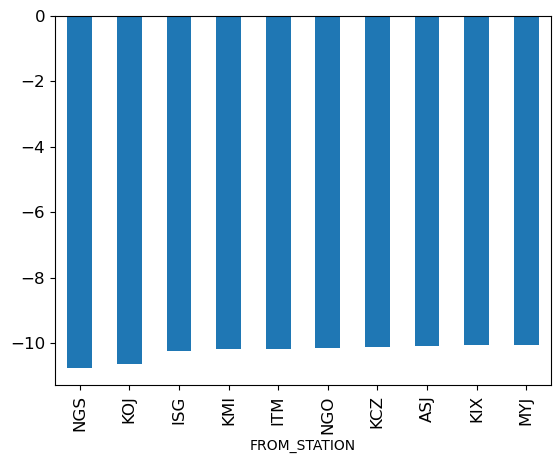

In [33]:
# Domestic flight
domestic_flight.groupby('FROM_STATION')\
['AVG_DELAY_MINUTE'].mean().sort_values().iloc[:10].plot.bar(fontsize=12)

<Axes: xlabel='FROM_STATION'>

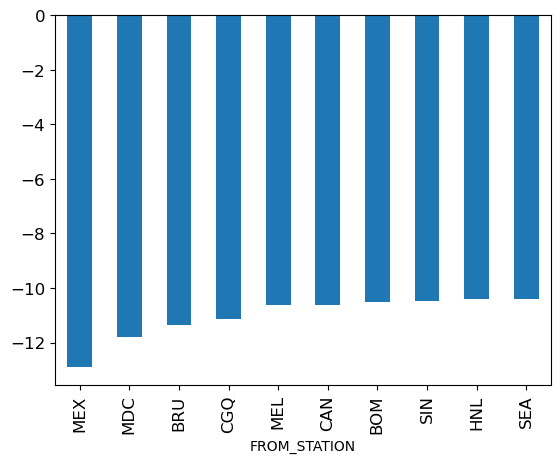

In [34]:
# International flight
international_flight.groupby('FROM_STATION')\
['AVG_DELAY_MINUTE'].mean().sort_values().iloc[:10].plot.bar(fontsize=12)

From the graph above, we can see that domestic flights from Nagasaki (NGS) and Kagoshima (KOJ) consistently arrive earlier than their estimated time, with no delays. For international flights, flights from Mexico (MEX) and Sam Ratulangi Manado (MDC) have a perfect on-time record, consistently arriving ahead of their estimated time.

### To Station

<Axes: xlabel='TO_STATION'>

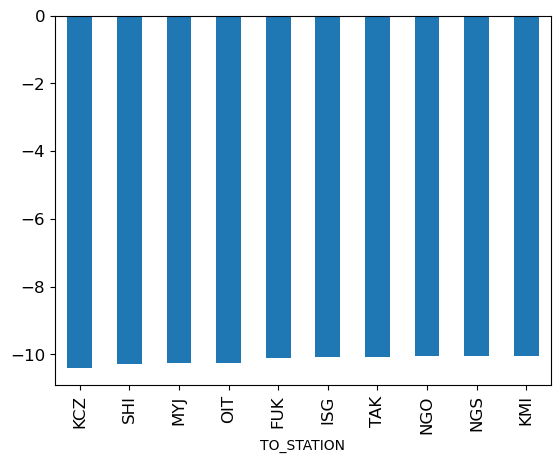

In [35]:
# Domestic flight
domestic_flight.groupby('TO_STATION')\
['AVG_DELAY_MINUTE'].mean().sort_values().iloc[:10].plot.bar(fontsize=12)

<Axes: xlabel='TO_STATION'>

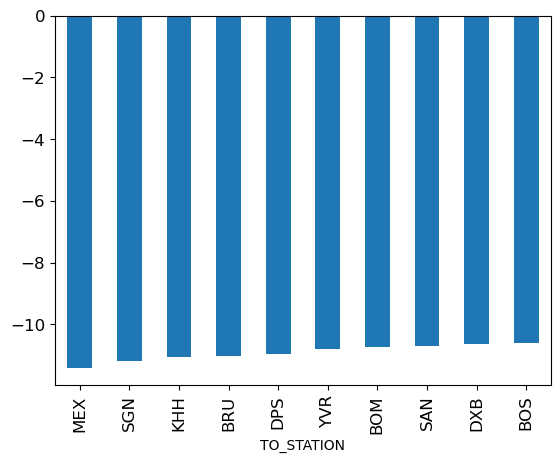

In [36]:
# International flight
international_flight.groupby('TO_STATION')\
['AVG_DELAY_MINUTE'].mean().sort_values().iloc[:10].plot.bar(fontsize=12)

From the graph above, we can observe that domestic flights from Narita to Kochi (KCZ) and Matsuyama (MYJ) consistently take off earlier than their scheduled time, with no delays. For international flights, flights from Kaohsiung (KHH) and Brussels (BRU) also maintain a perfect record of departing on time and flying ahead of their scheduled time.

## Create Data for Training

After we know about the data, i want to make a data mart for modelling later. So let's begin

In [37]:
def CreateDataMart(dataframe, group, time_interval):
    
    # get datamart per group 
    dw_data = dataframe[dataframe['GROUPER']==group]
    
    # aggregate date, capacity, dan pax
    aggregated_flight = pd.DataFrame(dw_data[["SCHEDULED_TIME", 'DATE']].groupby([pd.Grouper(key='SCHEDULED_TIME', freq=time_interval)]).count()).reset_index()
    aggregated_capacity = pd.DataFrame(dw_data[['SCHEDULED_TIME','CAPACITY']].groupby([pd.Grouper(key='SCHEDULED_TIME', freq=time_interval)]).sum()).reset_index()
    aggregated_pax = pd.DataFrame(dw_data[['ACTUAL_TIME','TOTAL_PAX']].groupby([pd.Grouper(key='ACTUAL_TIME', freq=time_interval)]).sum()).reset_index()

    # join the dataset
    ml_data = pd.merge(aggregated_flight, aggregated_pax, left_on = 'SCHEDULED_TIME', right_on = 'ACTUAL_TIME', how = 'left')
    ml_data = pd.merge(ml_data, aggregated_capacity, on = 'SCHEDULED_TIME', how = 'left')
    ml_data['GROUP'] = group
    
    # rename column
    ml_data = ml_data.rename(columns = {'DATE':'#FLIGHT', 'SCHEDULED_TIME':'TIMEFRAME'})
    
    # adding lagging and future lag for feature
    ml_data['#FLIGHT_NEXT_D'] = ml_data['#FLIGHT'].shift(-1)
    ml_data['#FLIGHT_NEXT_2D'] = ml_data['#FLIGHT'].shift(-2)
    ml_data['#FLIGHT_NEXT_3D'] = ml_data['#FLIGHT'].shift(-3)

    # shifting previous day
    ml_data['#FLIGHT_LAST_D'] = ml_data['#FLIGHT'].shift(1)
    ml_data['#FLIGHT_LAST_2D'] = ml_data['#FLIGHT'].shift(2)
    ml_data['#FLIGHT_LAST_3D'] = ml_data['#FLIGHT'].shift(3)
    return ml_data

In [38]:
# create datamart
time_interval = '1D'

data_mart = pd.DataFrame({})

for i in data_flight['GROUPER'].unique():
    data_mart = data_mart.append(CreateDataMart(data_flight, i, time_interval))


data_mart.sort_values("TIMEFRAME").reset_index(drop=True, inplace=True)
del i, time_interval
gc.collect()

/tmp/ipykernel_2813238/730041210.py:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_mart = data_mart.append(CreateDataMart(data_flight, i, time_interval))
/tmp/ipykernel_2813238/730041210.py:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_mart = data_mart.append(CreateDataMart(data_flight, i, time_interval))
/tmp/ipykernel_2813238/730041210.py:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_mart = data_mart.append(CreateDataMart(data_flight, i, time_interval))
/tmp/ipykernel_2813238/730041210.py:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_mart = data_mart.append(CreateDataMart(data_flight, i, time_interval))


51

In [39]:
data_mart.head()

,TIMEFRAME,#FLIGHT,ACTUAL_TIME,TOTAL_PAX,CAPACITY,GROUP,#FLIGHT_NEXT_D,#FLIGHT_NEXT_2D,#FLIGHT_NEXT_3D,#FLIGHT_LAST_D,#FLIGHT_LAST_2D,#FLIGHT_LAST_3D
0,2015-01-01,3,2015-01-01,276.0,480.0,2 (Domestic)-Japan Airlines-Domestic-Departure,3.0,3.0,3.0,NaN,NaN,NaN
1,2015-01-02,3,2015-01-02,299.0,566.0,2 (Domestic)-Japan Airlines-Domestic-Departure,3.0,3.0,1.0,3.0,NaN,NaN
2,2015-01-03,3,2015-01-03,332.0,539.0,2 (Domestic)-Japan Airlines-Domestic-Departure,3.0,1.0,2.0,3.0,3.0,NaN
3,2015-01-04,3,2015-01-04,445.0,513.0,2 (Domestic)-Japan Airlines-Domestic-Departure,1.0,2.0,3.0,3.0,3.0,3.0
4,2015-01-05,1,2015-01-05,114.0,162.0,2 (Domestic)-Japan Airlines-Domestic-Departure,2.0,3.0,3.0,3.0,3.0,3.0


## Feature Engineering Part 2

### Create Date, Month, Year, Weekday, and Weekend

In [40]:
# Create Date, Month, Year, Weekday, and Weekend
data_mart['TIME_DT'] = pd.to_datetime(data_mart['TIMEFRAME'])
data_mart['YEAR'] = data_mart['TIME_DT'].dt.year
data_mart['MONTH'] = data_mart['TIME_DT'].dt.month
data_mart['DAY'] = data_mart['TIME_DT'].dt.day
data_mart['WEEKDAY'] = data_mart['TIME_DT'].dt.weekday
data_mart['WEEKEND'] = np.where(data_mart['WEEKDAY']>=5, 1, 0)
data_mart.drop("TIME_DT", axis=1, inplace=True)

In [41]:
data_mart.head()

,TIMEFRAME,#FLIGHT,ACTUAL_TIME,TOTAL_PAX,CAPACITY,GROUP,#FLIGHT_NEXT_D,#FLIGHT_NEXT_2D,#FLIGHT_NEXT_3D,#FLIGHT_LAST_D,#FLIGHT_LAST_2D,#FLIGHT_LAST_3D,YEAR,MONTH,DAY,WEEKDAY,WEEKEND
0,2015-01-01,3,2015-01-01,276.0,480.0,2 (Domestic)-Japan Airlines-Domestic-Departure,3.0,3.0,3.0,NaN,NaN,NaN,2015,1,1,3,0
1,2015-01-02,3,2015-01-02,299.0,566.0,2 (Domestic)-Japan Airlines-Domestic-Departure,3.0,3.0,1.0,3.0,NaN,NaN,2015,1,2,4,0
2,2015-01-03,3,2015-01-03,332.0,539.0,2 (Domestic)-Japan Airlines-Domestic-Departure,3.0,1.0,2.0,3.0,3.0,NaN,2015,1,3,5,1
3,2015-01-04,3,2015-01-04,445.0,513.0,2 (Domestic)-Japan Airlines-Domestic-Departure,1.0,2.0,3.0,3.0,3.0,3.0,2015,1,4,6,1
4,2015-01-05,1,2015-01-05,114.0,162.0,2 (Domestic)-Japan Airlines-Domestic-Departure,2.0,3.0,3.0,3.0,3.0,3.0,2015,1,5,0,0


### Create Route Feature

I am gonna make a dummy column from <b>"FROM_STATION</b> and <b>TO_STATION</b> column to see how much flight or route for per group

In [42]:
# create flight date for dummy to pivot table :)
data_flight["FLIGHT_DATE"] = data_flight.DATE

In [43]:
# Route From Narita
departureFromNarita = pd.pivot_table(
    data_flight[data_flight['LEG']=='Departure'], 
    aggfunc = 'count', values = 'FLIGHT_DATE', 
    index = ['GROUPER','DATE'], columns = ['TO_STATION'], 
    fill_value = 0
).reset_index()

# Route to Narita
arrivalToNarita = pd.pivot_table(
    data_flight[data_flight['LEG']=='Arrival'],
    aggfunc='count', 
    values='FLIGHT_DATE', 
    index=['GROUPER','DATE'],
    columns=['FROM_STATION'], 
    fill_value = 0
).reset_index()

# Just adding some text for column route (departed and arrival)
for cols in departureFromNarita.columns[2:]:
    departureFromNarita.rename({cols:'DEPARTED_TO_'+cols}, axis=1, inplace=True)
departureFromNarita.rename_axis([None], axis=1, inplace=True)
departureFromNarita['DATE'] = pd.to_datetime(departureFromNarita['DATE'])
departureFromNarita.rename({'DATE':'TIMEFRAME'}, axis=1, inplace=True)

for cols in arrivalToNarita.columns[2:]:
    arrivalToNarita.rename({cols:'ARRIVAL_FROM_'+cols}, axis=1, inplace=True)
arrivalToNarita.rename_axis([None], axis=1, inplace=True)
arrivalToNarita['DATE'] = pd.to_datetime(arrivalToNarita['DATE'])
arrivalToNarita.rename({'DATE':'TIMEFRAME'}, axis=1, inplace=True)

In [44]:
# Concat all dataset route into one variable, and aggregate it
all_route = pd.concat([arrivalToNarita, departureFromNarita], axis=0).fillna(0).sort_values('TIMEFRAME').reset_index(drop=True)
all_route = all_route.groupby(['TIMEFRAME', 'GROUPER']).sum().reset_index().copy()

In [45]:
all_route.head()

,TIMEFRAME,GROUPER,ARRIVAL_FROM_ADD,ARRIVAL_FROM_AMS,ARRIVAL_FROM_ASJ,ARRIVAL_FROM_AUH,ARRIVAL_FROM_BKK,ARRIVAL_FROM_BOM,ARRIVAL_FROM_BOS,ARRIVAL_FROM_BRU,...,DEPARTED_TO_SAN,DEPARTED_TO_SEA,DEPARTED_TO_SFO,DEPARTED_TO_SGN,DEPARTED_TO_SHI,DEPARTED_TO_SIN,DEPARTED_TO_TAK,DEPARTED_TO_TAO,DEPARTED_TO_TPE,DEPARTED_TO_YVR
0,2015-01-01,1 (Domestic)-All Nippon Airways-Domestic-Arrival,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2015-01-01,1 (Domestic)-All Nippon Airways-Domestic-Depar...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2015-01-01,1 (Domestic)-Peach Aviation Limited-Domestic-A...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,2015-01-01,1 (Domestic)-Peach Aviation Limited-Domestic-D...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,2015-01-01,1 (International/North)-China Southern Airline...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Create Aggregate Feature

In [46]:
# make an aggregate value from avg_delay_minute
agg_dataframe = data_flight.groupby(['DATE', 'GROUPER']).agg({"AVG_DELAY_MINUTE":"mean"}).reset_index()
agg_dataframe['DATE'] = pd.to_datetime(agg_dataframe['DATE']) 
agg_dataframe.rename({'DATE':'TIMEFRAME'}, axis=1, inplace=True)

In [47]:
agg_dataframe.head()

,TIMEFRAME,GROUPER,AVG_DELAY_MINUTE
0,2015-01-01,1 (Domestic)-All Nippon Airways-Domestic-Arrival,15.000000
1,2015-01-01,1 (Domestic)-All Nippon Airways-Domestic-Depar...,-6.000000
2,2015-01-01,1 (Domestic)-Peach Aviation Limited-Domestic-A...,-5.150000
3,2015-01-01,1 (Domestic)-Peach Aviation Limited-Domestic-D...,-4.842105
4,2015-01-01,1 (International/North)-China Southern Airline...,-4.333333


### Join All Feature

In [48]:
data_mart['TIMEFRAME'] = pd.to_datetime(data_mart['TIMEFRAME']) 
data_mart_ready = pd.merge(
    data_mart, 
    all_route, 
    left_on = ['GROUP','TIMEFRAME'], 
    right_on = ['GROUPER','TIMEFRAME'], 
    how = 'inner'
)

In [49]:
data_mart_ready = pd.merge(
    data_mart_ready, 
    agg_dataframe, 
    left_on = ['GROUP','TIMEFRAME'], 
    right_on = ['GROUPER','TIMEFRAME'], 
    how = 'inner'
)

### Remove Column contains _x or _y

In [50]:
# remove column that contains _x and _y taht might be shown after joining table
listRemove = list()
for cols in data_mart_ready.columns:
    patt_x = re.compile(r"\w+_x$")
    patt_y = re.compile(r"\w+_y$")
    if ((patt_x.findall(cols) != []) | (patt_y.findall(cols) != [])):
        listRemove.append(cols)
    else:
        pass

data_mart_ready.drop(listRemove, axis=1, inplace=True)

del cols, listRemove
gc.collect()

0

### ADD Pandemic & OTP Column

adding pandemic column because in 2020-2022 all around the world had pandemic COVID-19, and because of that there is restriction to flight to another country. It might be affect the schedule flight in Narita. And for OTP, i am just added again because i can't aggregate it before. :)

In [51]:
def PandemicFlag(data):
    years = data.year
    months = data.month
    if (years == 2020) & (months >=4):
        return True
    elif (years == 2021) | (years == 2022):
        return True
    else:
        return False

def OTPFlag(value):
    if value < 0:
        return "EARLY"
    elif (value>=0) & (value<=10):
        return "ON_TIME"
    elif (value>10) & (value<=20):
        return "CAT_1"
    elif (value>20) & (value<=30):
        return "CAT_1"
    else:
        return "CAT_3"

In [52]:
# adding column pandemic and otp
data_mart_ready['PANDEMIC'] = data_mart_ready.TIMEFRAME.apply(PandemicFlag)
data_mart_ready["OTP"] = data_mart_ready.AVG_DELAY_MINUTE.apply(OTPFlag)

### Breakdown Group

In [53]:
# breakdown group again for feature in modelling
new = data_mart_ready['GROUP'].str.split('-', expand = True)
data_mart_ready['TERMINAL'] = new[0]
data_mart_ready['AIRLINE'] = new[1]
data_mart_ready['CATEGORY_CODE'] = new[2]
data_mart_ready['LEG'] = new[3]

# Modelling

## Preprocess

In [54]:
# Get list rouete feature
route = list()
for cols in data_mart_ready.columns:
    if 'FROM_' in cols:
        route.append(cols)
    elif 'TO_' in cols:
        route.append(cols)
    else:
        pass

In [93]:
# Set The Feature for XBOOST REGRESSOR

num_features = [
    "#FLIGHT",
    "#FLIGHT_NEXT_D",
    "#FLIGHT_LAST_D",
    "#FLIGHT_NEXT_2D",
    "#FLIGHT_LAST_2D",
    "#FLIGHT_NEXT_3D",
    "#FLIGHT_LAST_3D",
    "PANDEMIC",
    "CAPACITY",
    "AVG_DELAY_MINUTE",
] + route

cat_features = [
    "YEAR",
    "MONTH",
    "WEEKDAY",
    "WEEKEND",
    "DAY",
    "OTP",
    "TERMINAL",
    "AIRLINE",
    "LEG",
    "CATEGORY_CODE",

]

features = num_features + cat_features

In [94]:
# Set X and Y for training
X = data_mart_ready[features].copy()
Y = data_mart_ready['TOTAL_PAX'].copy()

# Logging the y value, to normalize the pax value
Y = round(np.log(Y), 4)

In [95]:
# use binary encoding to encode two categorical features
enc = ce.TargetEncoder(cols=cat_features).fit(X[cat_features], Y)
X[cat_features] = enc.transform(X[cat_features])

In [96]:
# scalling the numerical feature for modelling
rob_scaler = RobustScaler().fit(X[num_features])

X[num_features] = rob_scaler.transform(X[num_features])

In [97]:
# create time cut for split data train and data test
time_cut = '2023-03-01'

ml_data_train = data_mart_ready[data_mart_ready['TIMEFRAME']<=time_cut].copy()
ml_data_test = data_mart_ready[data_mart_ready['TIMEFRAME']>time_cut].copy()

X_train = X[data_mart_ready['TIMEFRAME']<=time_cut].copy()
X_test = X[data_mart_ready['TIMEFRAME']>time_cut].copy()

Y_train = Y[data_mart_ready['TIMEFRAME']<=time_cut].copy()
Y_test = Y[data_mart_ready['TIMEFRAME']>time_cut].copy()

In [98]:
# create function for smape metric
def SMAPE(Y_true, Y_pred):
    Y_true = np.array(Y_true)
    Y_pred = np.array(Y_pred)
    n = len(Y_true)
    
    sum_series = np.where(abs(Y_true) + abs(Y_pred) == 0, 0, abs(Y_true - Y_pred)/((abs(Y_true) + abs(Y_pred))/2))    
    return np.mean(sum_series)

# deine metric for regression results
def RegressionResult(y_true, y_pred):
# Regression metrics
    explained_variance=explained_variance_score(y_true, y_pred)
    mae=mean_absolute_error(y_true, y_pred)
    mse=mean_squared_error(y_true, y_pred)
    mape=mean_absolute_percentage_error(y_true, y_pred)
    smape_metrics = SMAPE(y_true, y_pred)
    r2=r2_score(y_true, y_pred)
    print('explained_variance: ', round(explained_variance,4))
    print('r2: ', round(r2,4))
    print('MAE: ', round(mae,4))
    print('MSE: ', round(mse,4))
    print('MAPE: ', round(mape,4))
    print('SMAPE: ', round(smape_metrics,4))
    print('RMSE: ', round(np.sqrt(mse),4))\

    fig = px.scatter(x = y_pred,y = y_true-y_pred)
    fig.add_hline(y=0)
    fig.add_hline(y=round(1.96*np.sqrt(mse),4))
    fig.add_hline(y=-round(1.96*np.sqrt(mse),4))
    fig.update_layout(title_text='Pax Prediction Residue', title_x=0.5)
    fig.show()

In [99]:
# Set the XGBOOST Regressor Parameter (Parameter i get with randomizedCV in google colab XD )
xgbr = XGBRegressor(
    seed=42, 
    scoring='neg_mean_squared_error', 
    subsample= 0.9,
    objective= 'reg:squarederror',
    n_estimators= 500,
    min_child_weight= 8,
    max_depth= 5,
    gamma= 0.3,
    eval_metric= 'rmse',
    eta= 0.4,
    colsample_bytree= 1.0,
    booster= 'gbtree'
)

In [100]:
# fitting the model
xgbr.fit(X_train, Y_train)

[06:53:34] WARNING: ../src/learner.cc:767: 
Parameters: { "scoring" } are not used.



XGBRegressor(base_score=None, booster='gbtree', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=1.0, early_stopping_rounds=None,
             enable_categorical=False, eta=0.4, eval_metric='rmse',
             feature_types=None, gamma=0.3, gpu_id=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=None, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=5,
             max_leaves=None, min_child_weight=8, missing=nan,
             monotone_constraints=None, n_estimators=500, n_jobs=None,
             num_parallel_tree=None, predictor=None, ...)

In [101]:
# predict data
Y_pred = xgbr.predict(X_test)

In [102]:
# inverse all log value
Y_pred = round(pd.Series(np.exp(Y_pred))).to_numpy()
Y_test_normalized = round(np.exp(Y_test))

In [103]:
# see the result from the model
RegressionResult(Y_test_normalized, Y_pred)

explained_variance:  0.986
r2:  0.9854
MAE:  85.7391
MSE:  20185.2308
MAPE:  0.1928
SMAPE:  0.1693
RMSE:  142.0747


well from that result, actually the model it was ok. We got R-Squared 97% and SMAPE 16%. But the Residue it was little bit higher

In [104]:
# just create a look var to see the result prediction
def getDate(the_date):
    result = str(the_date).split(' ')[0]
    
    return result
    
ml_data_test['PAX_PRED'] = Y_pred
ml_data_test['PAX_MISSED'] = ml_data_test['TOTAL_PAX'] - ml_data_test['PAX_PRED']
ml_data_test['PAX_MISSED_ABS'] = abs(ml_data_test['PAX_MISSED'])

LOOK_VAR = ['TIMEFRAME','TERMINAL','AIRLINE','CATEGORY_CODE','LEG','#FLIGHT','CAPACITY','TOTAL_PAX','PAX_PRED','PAX_MISSED','PAX_MISSED_ABS']

ml_data_test['DATE'] = ml_data_test['TIMEFRAME'].apply(getDate)

ml_data_test[LOOK_VAR].head(20)

,TIMEFRAME,TERMINAL,AIRLINE,CATEGORY_CODE,LEG,#FLIGHT,CAPACITY,TOTAL_PAX,PAX_PRED,PAX_MISSED,PAX_MISSED_ABS
2727,2023-03-02,2 (Domestic),Japan Airlines,Domestic,Departure,2,371.0,297.0,252.0,45.0,45.0
2728,2023-03-03,2 (Domestic),Japan Airlines,Domestic,Departure,2,371.0,184.0,260.0,-76.0,76.0
2729,2023-03-04,2 (Domestic),Japan Airlines,Domestic,Departure,2,672.0,366.0,399.0,-33.0,33.0
2730,2023-03-05,2 (Domestic),Japan Airlines,Domestic,Departure,1,156.0,105.0,117.0,-12.0,12.0
2731,2023-03-06,2 (Domestic),Japan Airlines,Domestic,Departure,2,371.0,270.0,229.0,41.0,41.0
2732,2023-03-07,2 (Domestic),Japan Airlines,Domestic,Departure,3,830.0,491.0,468.0,23.0,23.0
2733,2023-03-08,2 (Domestic),Japan Airlines,Domestic,Departure,2,619.0,356.0,380.0,-24.0,24.0
2734,2023-03-09,2 (Domestic),Japan Airlines,Domestic,Departure,2,318.0,187.0,225.0,-38.0,38.0
2735,2023-03-10,2 (Domestic),Japan Airlines,Domestic,Departure,2,342.0,250.0,252.0,-2.0,2.0
2736,2023-03-11,2 (Domestic),Japan Airlines,Domestic,Departure,1,156.0,78.0,105.0,-27.0,27.0


In [112]:
# create function to see metric results from model
def reportsResult(dataframe):
    groupList = list()
    for groups in dataframe.GROUP.unique():
        groupDict = dict()
        listSplit = groups.split('-')
        groupDict['TERMINAL'] = listSplit[0]
        groupDict['AIRLINE'] = listSplit[1]
        groupDict['CATEGORY_CODE'] = listSplit[2]
        groupDict['LEG'] = listSplit[3]


        tempdf = dataframe[dataframe['TERMINAL'] == groupDict['TERMINAL']]\
                    [dataframe['AIRLINE'] == groupDict['AIRLINE']]\
                    [dataframe['CATEGORY_CODE'] == groupDict['CATEGORY_CODE']]\
                    [dataframe['LEG'] == groupDict['LEG']].copy()
        r2 = r2_score(tempdf['PAX_PRED'], tempdf['TOTAL_PAX'])
        smape_metric = SMAPE(tempdf['PAX_PRED'], tempdf['TOTAL_PAX'])

        groupDict['R2_SCORE'] = r2
        groupDict['SMAPE'] = smape_metric
        groupList.append(groupDict)

        report = pd.DataFrame(groupList)
    report = report[['AIRLINE', 'TERMINAL', 'LEG', 'CATEGORY_CODE', 'R2_SCORE', 'SMAPE']].sort_values('AIRLINE').reset_index(drop=True)
    
    return report

def view_forecast(dataframe, terminal, airline, category_code, leg, show_pred=False):
    if show_pred:
        df_temp = dataframe[(dataframe['TERMINAL']==terminal)&\
                            (dataframe["AIRLINE"]==airline)&\
                            (dataframe['CATEGORY_CODE']==category_code)&\
                            (dataframe['LEG']==leg).copy()] 
        fig = go.Figure([go.Scatter(name = 'PAX_ACTUAL',x = df_temp['TIMEFRAME'], y = df_temp['TOTAL_PAX'])])
        fig.add_trace(go.Scatter(name="PAX_PREDICTION", x=df_temp['TIMEFRAME'], y=df_temp['PAX_PRED']))
        fig.update_xaxes(rangeslider_visible=True)
        fig.update_layout(title_text='Pax Prediction for {} Airline'.format(airline), title_x=0.45)
        fig.show()
    
    else:
        df_temp = dataframe[(dataframe['TERMINAL']==terminal)&\
                            (dataframe["AIRLINE"]==airline)&\
                            (dataframe['CATEGORY_CODE']==category_code)&\
                            (dataframe['LEG']==leg).copy()] 
        fig = go.Figure([go.Scatter(name = 'PAX_RESIDUE',x = df_temp['TIMEFRAME'], y = df_temp['PAX_MISSED'])])
        fig.update_xaxes(rangeslider_visible=True)
        fig.update_layout(title_text='Pax Prediction Residue', title_x=0.5)
        fig.show()

In [106]:
reportsResult(ml_data_test)

/tmp/ipykernel_2813238/889054272.py:13: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.

/tmp/ipykernel_2813238/889054272.py:13: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.

/tmp/ipykernel_2813238/889054272.py:13: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.

/tmp/ipykernel_2813238/889054272.py:13: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.

/tmp/ipykernel_2813238/889054272.py:13: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.

/tmp/ipykernel_2813238/889054272.py:13: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.

/tmp/ipykernel_2813238/889054272.py:13: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.

/tmp/ipykernel_2813238/889054272.py:13: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.

/tmp/ipykernel_2813238/889054272.py:13: UserWarning:

Bo

,AIRLINE,TERMINAL,LEG,CATEGORY_CODE,R2_SCORE,SMAPE
0,All Nippon Airways,1 (International/South),Arrival,International,0.808887,0.101481
1,All Nippon Airways,1 (International/South),Departure,International,0.693979,0.181239
2,All Nippon Airways,1 (Domestic),Arrival,Domestic,0.823689,0.186903
3,All Nippon Airways,1 (Domestic),Departure,Domestic,0.498993,0.148305
4,Batik Air Malaysia (Malindo),2 (International),Departure,International,0.454037,0.224076
5,Batik Air Malaysia (Malindo),2 (International),Arrival,International,0.703435,0.289923
6,Cathay Pacific,2 (International),Arrival,International,0.695071,0.167328
7,Cathay Pacific,2 (International),Departure,International,0.903654,0.130532
8,Cebu Pacific Air,2 (International),Arrival,International,0.775877,0.174840
9,Cebu Pacific Air,2 (International),Departure,International,0.555753,0.145697


In [114]:
view_forecast(ml_data_test, "1 (Domestic)", "All Nippon Airways", "Domestic", "Arrival", show_pred=True)

# Feature Importance

In [107]:
# create function to get dataframe that had importance metric in it
def ImportanceDataFrame(dataframe, model):
    sorted_idx = model.feature_importances_.argsort()
    tempList = list()
    tempDict = dict()
    for cols, value in zip(dataframe[features].columns[sorted_idx], model.feature_importances_[sorted_idx]):
        tempDict[cols] = value
    tempList.append(tempDict)
    importanceDF = pd.DataFrame(tempList)
    return importanceDF

In [108]:
importanceDF = ImportanceDataFrame(ml_data_test, xgbr)

In [109]:
# Function for aggregate all feature route into one
def groupImportance(dataframe, features):
    TO_STATION = list()
    FROM_STATION = list()
    for cols in features:
        if re.search(r'_TO',cols):
            TO_STATION.append(cols)
        elif re.search(r'_FROM',cols):
            FROM_STATION.append(cols)
        else:
            pass
    ROUTE = FROM_STATION + TO_STATION 
        
    tempDict = dict()
    tempList = list()
    for group, names in zip([ROUTE],["ROUTE"]):
        tempDict[names] = dataframe[group].sum(axis=1)[0]
    tempList.append(tempDict)
    
    dataframe = dataframe.drop(ROUTE,axis=1)
    dataframe = pd.concat([dataframe, pd.DataFrame(tempList)], axis=1)
    dataframe = dataframe.T.rename({0:'IMPORTANCE_VALUE'}, axis=1)
        
    return dataframe

In [110]:
importanceDF = groupImportance(importanceDF, importanceDF.columns)

<Axes: >

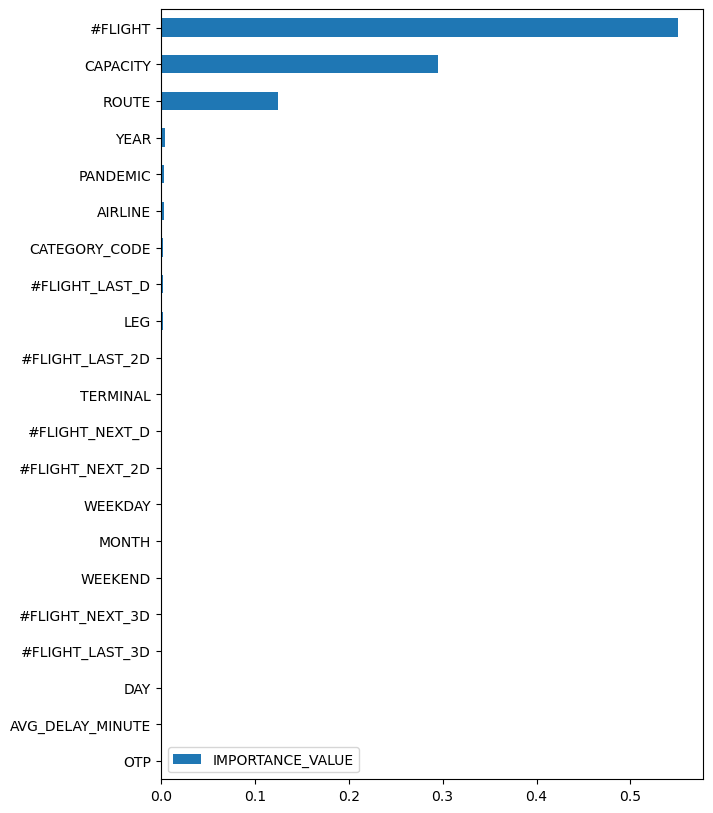

In [111]:
importanceDF.sort_values('IMPORTANCE_VALUE').plot(kind = 'barh', figsize = (7,10,))

# Conclusion

From the outcomes of the conducted data exploration and modeling, the features of total flights in a day for each Group (Terminal - Airline - Category Code - Leg), Aircraft Capacity, and Flight Route have emerged as the most significant factors in the model.

There's still much more to explore, such as attempting to train models by aggregating timeframes to consider Date for an overall view of passenger patterns at Narita. It could also involve training per-terminal due to the distinct characteristics of each terminal or training to analyze passenger patterns per hour, potentially for developing an Early Warning system for terminal congestion caused by high passenger volumes. Unfortunately, these tasks are unfeasible due to the lack of original data. Nevertheless, I thoroughly enjoyed working on this independent project.